## Определение тональности отзывов на банки
---

### Условия
Максимальный балл за задачу: 400

Вам необходимо создать модель машинного обучения для определения тональности текстов отзывов на банки. Тексты отзывов на русском языке. Тональность отзывов может быть положительной или отрицательной.

### Набор данных
Данные включают отзывы о работе различных банков, собранные с сайта banki.ru. Для каждого отзыва есть метка тональности:
* Positive - Отзыв положительный
* Negative - Отзыв отрицательный
Формат данных: файл csv, разделитель табуляция.

Два столбца:
* Label - метка класса, положительный или отрицательный отзыв.
* Text - текст отзыва.
 
### Пример данных:

Positive:
> Обслуживаюсь на Цветном Бульваре. Продукт - кредитная карта. Все ясно и четко. Грамотные работники колл-центра - так держать. Являюсь клиентом уже 3-й год. Очень доволен - молодцы!В прошлом году была просрочка по платежам месяца полтора, истратил весь лимит - была сложная фин. ситуация и смена работы. Никто не парил мозг звонками - позвонили один раз, в ОЧЕНЬ ТАКТИЧНОЙ И ВЕЖЛИВОЙ форме напомнили о просрочке, спросили, когда БУДЕТ ВОЗМОЖНОСТЬ погасить задолженность. Ответил - через 3 недели. Все ОК, ждем. Больше НИ ОДНОГО звонка.Была проблема с оплатой через интернет. Позвонил. Ответили, что данный ресурс заблокирован и операция отменена банком. Попросил разблокировать - все решили в течение 10 минут. Вежливые операционисты. Поймал себя на том, что когда звоню в колл-центр, то звоню к людям, которые помогут решить мою проблему, а не с негативом и желанием ругаться уже заранее, как в некоторые другие банковские заведения.В общем, спасибо за хороший сервис и грамотных специалистов!

Negative:
> Никаких скрытых комиссий, банк ништяк. Только после оформления кредита выясняется, что зачем-то застраховали тебя, хотя я и не просил, и она не говорила, что будем Вас страховать на 1135 руб. Ещё дали наклейки сказали, что подарок. Наклеишь, мол, на паспорт эту наклейку и в случае утери всё будет окей, или вернём паспорт, или 1000 рублей. Ну вот этот подарок обошёлся мне в 1000 руб. Дальше СМС-информатор 294 руб. Брал PS3 в М-Видео Нижнекамск. Все эти цифры должны быть озвучены до оформления кредита. Администратор: Уточните, пожалуйста, дату оформления кредита. 9v3: Закрыл я уже кредит, а брал 09.10.13.

### Метрика

В качестве метрики используется Accuracy (доля правильных ответов).
> Accuracy = C / N

, где
* С – количество правильно классифицированных объектов.
* N – общее количество объектов.

Балл за задачу рассчитывается по формуле:
> Points = 400  max(0, (Accuracy  2 - 1))

, где
* Points – количество баллов.
* Accuracy – доля правильных ответов.
* max – используется для того, чтобы не допустить отрицательных баллов, если решение дает метрику < 0.5.

Таким образом, при значении метрики *Accuracy < 0.5*, за задачу будет начислено 0 баллов. А значения метрики в диапазоне *0.5 ≤  Accuracy < 1.0* пропорционально преобразуются в баллы от 0.0 до 400.0

### Данные
* [train.csv](train.csv)
* [test.csv](test.csv)
* [sample_submission.csv](sample_submission.csv)


## Решение
---

Подключаем необходимые библиотеки

In [1]:
import pandas
import re
from tensorflow import keras
import sklearn.model_selection
import matplotlib.pyplot as plt
import numpy
import seaborn

Определяем GPU доступные для использования

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

---
Читаем данные для обучения в [Pandas Dataframe](https://www.w3schools.com/python/pandas/pandas_dataframes.asp)

In [3]:
train_data = pandas.read_csv('train.csv', sep='\t', index_col='idx')
train_data

,Score,Text
idx,,
0,Positive,В Альфа-Банке работает замечательная девушка -...
1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...
2,Positive,Очень порадовала оперативность работы в банке....
3,Negative,Имела неосторожность оформить потреб. кредит в...
4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...
...,...,...
13994,Positive,"О высокой надёжности МКБ, порядочности и добро..."
13995,Positive,"Обслуживаюсь в офисе на Чернореченской 42а, ка..."
13996,Positive,Попала сегодня в очень неприятную ситуацию. Ре...


---
Предварительная обработка отзывов:
* Приведение к нижнему регистру
* Замена «ё» на «е»
* Замена ссылок на токен «URL»
* Замена e-mail адресов на токен «URL»
* Удаление знаков пунктуации

In [4]:
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', 'EMAIL', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

train_data['review'] = train_data['Text'].apply(lambda x: preprocess_text(x))
train_data

,Score,Text,review
idx,,,
0,Positive,В Альфа-Банке работает замечательная девушка -...,в альфа банке работает замечательная девушка и...
1,Negative,Оформляя рассрочку в м. Видео в меге тёплый ст...,оформляя рассрочку в м видео в меге теплый ста...
2,Positive,Очень порадовала оперативность работы в банке....,очень порадовала оперативность работы в банке ...
3,Negative,Имела неосторожность оформить потреб. кредит в...,имела неосторожность оформить потреб кредит в ...
4,Negative,Небольшая предыстория: Нашел на сайте MDM банк...,небольшая предыстория нашел на сайте mdm банка...
...,...,...,...
13994,Positive,"О высокой надёжности МКБ, порядочности и добро...",о высокой надежности мкб порядочности и доброс...
13995,Positive,"Обслуживаюсь в офисе на Чернореченской 42а, ка...",обслуживаюсь в офисе на чернореченской 42а как...
13996,Positive,Попала сегодня в очень неприятную ситуацию. Ре...,попала сегодня в очень неприятную ситуацию реш...


---
Cоздаем и обучаем токенизатор на основе текстов отзывов

In [5]:
MAX_DICTIONARY_SIZE = 500000                                                # Размер словаря
MAX_SEQUENCE_LENGTH = max(train_data['review'].str.split().str.len())       # Максимальное количество слов в отзыве

tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_DICTIONARY_SIZE, filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['review'].values)

VOCABULARY_SIZE = len(tokenizer.word_index)
print('В отзывах найдено и токенизировано {} уникальных слов'.format(VOCABULARY_SIZE))

В отзывах найдено и токенизировано 102387 уникальных слов


---
Отображаем текст каждого отзыва в массив идентификаторов токенов и дополняем до единой размерности. Собираем подготовленные данные в переменную X

In [6]:
X = tokenizer.texts_to_sequences(train_data['review'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Размерность X: {}'.format(X.shape))
print('X: {}'.format(X))

Размерность X: (13999, 4035)
X: [[    0     0     0 ...    41    22   427]
 [    0     0     0 ...   807   186  4629]
 [    0     0     0 ...   469   513 19123]
 ...
 [    0     0     0 ...    60   164   121]
 [    0     0     0 ...     2  3100   866]
 [    0     0     0 ... 36254    64    25]]


---
Делаем OneHotEncoding для меток отзывов. Собираем данные в переменную Y

In [7]:
classes = pandas.get_dummies(train_data['Score'])
class_names = list(classes.columns)
Y = classes.values
print('Классы меток: {}'.format(class_names))
print('Размерность Y: {}'.format(Y.shape))
print('Y: {}'.format(Y))

Классы меток: ['Negative', 'Positive']
Размерность Y: (13999, 2)
Y: [[0 1]
 [1 0]
 [0 1]
 ...
 [0 1]
 [0 1]
 [1 0]]


---
Разбиваем набор данных на обучающую и проверочную выборку в пропорции 9:1

In [8]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=2)

print('Размерность x_train и y_train: {} {}'.format(x_train.shape, y_train.shape))
print('Размерность x_val и y_val: {} {}'.format(x_val.shape, y_val.shape))

Размерность x_train и y_train: (12599, 4035) (12599, 2)
Размерность x_val и y_val: (1400, 4035) (1400, 2)


---
Защищаемся от переобучения, определяя функцию ранеего останова по параметру val_loss

In [9]:
earlyStop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
)

---
Строим  и компилируем модель

In [10]:
EMBEDDING_DIM = 128

model = keras.Sequential()

model.add(keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=X.shape[1], name='Embedding'))
model.add(keras.layers.LSTM(100, dropout=0.0, recurrent_dropout=0, name='LSTM'))
model.add(keras.layers.Dense(Y.shape[1], activation='softmax', name='Dense_SoftMax'))

model.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])  # binary_crossentropy
#model.compile(optimizer = keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])  # binary_crossentropy

loss = [None]
val_loss = [None]
accuracy = [None]
val_accuracy = [None]
runs = []

print(model.summary())
#keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False, show_layer_activations=True)

2022-10-03 13:03:35.556080: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 13:03:36.503964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 4035, 128)         13105536  
                                                                 
 LSTM (LSTM)                 (None, 100)               91600     
                                                                 
 Dense_SoftMax (Dense)       (None, 2)                 202       
                                                                 
Total params: 13,197,338
Trainable params: 13,197,338
Non-trainable params: 0
_________________________________________________________________
None


---
Обучаем модель и стороим графики

2022-10-03 13:03:37.650064: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 203347860 exceeds 10% of free system memory.


Epoch 1/10


2022-10-03 13:03:41.407099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8500
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/targets/x86_64-linux/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


50/50 [==============================] - 25s 418ms/step - loss: 0.5918 - accuracy: 0.7113 - val_loss: 0.4292 - val_accuracy: 0.8286
Epoch 2/10
50/50 [==============================] - 20s 409ms/step - loss: 0.1889 - accuracy: 0.9342 - val_loss: 0.2186 - val_accuracy: 0.9214
Epoch 3/10
50/50 [==============================] - 21s 411ms/step - loss: 0.0529 - accuracy: 0.9855 - val_loss: 0.1811 - val_accuracy: 0.9350
Epoch 4/10
50/50 [==============================] - 21s 415ms/step - loss: 0.0166 - accuracy: 0.9962 - val_loss: 0.1820 - val_accuracy: 0.9414
Epoch 5/10
50/50 [==============================] - 21s 413ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.1952 - val_accuracy: 0.9429


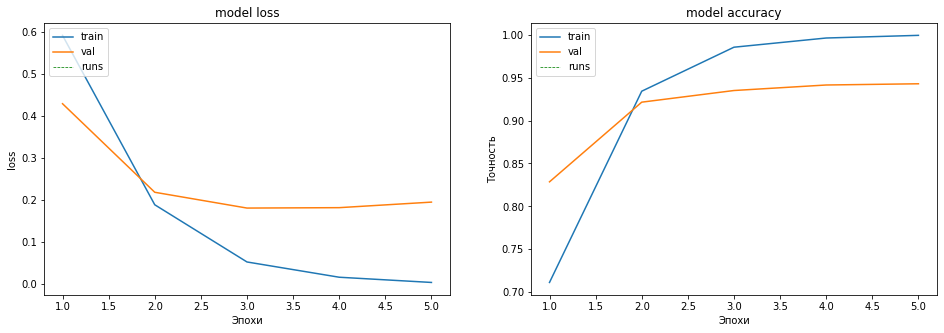

In [11]:
BATCH_SIZE = 256
EPOCHS = 10

history = model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    shuffle = True,
    callbacks = [earlyStop],
)

loss += history.history['loss']
val_loss += history.history['val_loss']
accuracy += history.history['accuracy']
val_accuracy += history.history['val_accuracy']
runs += [max(runs, default=0) + len(history.history['loss'])]

fig = plt.figure(figsize=(16, 5))

ax = fig.add_subplot(121)
ax.plot(loss)
ax.plot(val_loss)
ax.vlines(runs[:-1], plt.ylim()[0], plt.ylim()[1], label='Restart fit', color='green', linestyle = '--', linewidth=0.75)
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('Эпохи')
ax.legend(['train', 'val', 'runs'], loc='upper left')

ax = fig.add_subplot(122)
ax.plot(accuracy)
ax.plot(val_accuracy)
ax.vlines(runs[:-1], plt.ylim()[0], plt.ylim()[1], label='Restart fit', color='green', linestyle = '--', linewidth=0.75)
ax.set_title('model accuracy')
ax.set_ylabel('Точность')
ax.set_xlabel('Эпохи')
ax.legend(['train', 'val', 'runs'], loc='upper left')

---
Построение матрицы ошибок (Confusion Matrix)

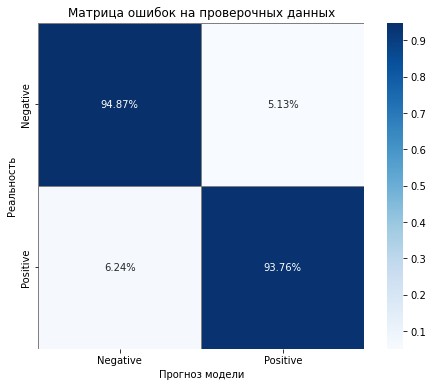

In [12]:
y_pred = model.predict(x_val)

cm = sklearn.metrics.confusion_matrix(
    y_true = [class_names[numpy.argmax(i)] for i in y_val],
    y_pred = [class_names[numpy.argmax(i)] for i in y_pred],
    labels = class_names,
)

cmn = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

plt.figure(figsize=(8,6))
ax = seaborn.heatmap(cmn, annot=True, fmt='.2%', xticklabels=class_names, yticklabels=class_names, cmap='Blues', square=True, linewidths=0.5, linecolor='gray')
ax.set_title('Матрица ошибок на проверочных данных');
ax.set_xlabel('Прогноз модели')
ax.set_ylabel('Реальность');
plt.show()

## Тестовые данные

---
Загружаем тестовые данные и делаем их предварительную обработку с использованием ранее опредленной функции preprocess_text()

In [13]:
test_data = pandas.read_csv('test.csv', sep='\t', index_col='idx')
test_data['review'] = test_data['Text'].apply(lambda x: preprocess_text(x))

---
Отображаем текст каждого отзыва в массив идентификаторов токенов ранее созданного токенайзера. Собираем подготовленные данные в переменную x_test

In [14]:
x_test = tokenizer.texts_to_sequences(test_data['review'].values)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

---
Предсказываем по тестовым данным

In [15]:
y_test = model.predict(x_test)

---
Добавляем в тестовые данные столбец с предсказаниями модели

In [16]:
test_data['Score'] = [class_names[numpy.argmax(i)] for i in y_test]
test_data

,Text,review,Score
idx,,,
13999,Замечательная история об открытии счета в банк...,замечательная история об открытии счета в банк...,Negative
14000,"23.07.14г. я досрочно внес сумму, указанную оп...",23 7 14г я досрочно внес сумму указанную опера...,Negative
14001,Была задолженность по кредитной карте. Банк по...,была задолженность по кредитной карте банк под...,Negative
14002,Срочно понадобилась определенная денежная сумм...,срочно понадобилась определенная денежная сумм...,Negative
14003,Здравствуйте. В местном отделении Бинбанка г. ...,здравствуйте в местном отделении бинбанка г ку...,Negative
...,...,...,...
19994,Уважаемые представители Русфинанс Банка! Прошу...,уважаемые представители русфинанс банка прошу ...,Positive
19995,04 июня сняли с дебетовой карты банка 10 000 T...,4 июня сняли с дебетовой карты банка 1 twd 12 ...,Positive
19996,В апреле решил я купить шуруповерт. Посмотрел ...,в апреле решил я купить шуруповерт посмотрел ц...,Negative


---
Сохраняем результат в файл submission.csv

In [17]:
test_data.to_csv('submission.csv', sep='\t', index=True, columns=['Score'])